In [2]:
import xgboost
print("xgboost", xgboost.__version__)

xgboost 1.2.0


In [8]:
# define model
from xgboost.sklearn import XGBRegressor
model = XGBRegressor()

In [27]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

In [10]:
# convert time series data to supervised learning dataset

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # output sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-1))
    # concat
    agg = pd.concat(cols, axis=1)
    # drop rows with nan
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values


In [12]:
# define train_test_split function

def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [30]:
# fit a xgboost model to make a one-step prediction

def xgboost_forecast(train, testX):
    # transform list into arrary
    train = np.asarray(train)
    # split train row into inputs and outputs
    trainX, trainy = train[:, :-1], train[:,-1]
    # fit the model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

In [23]:
# K-fold CV cannot be used because you cannot use data from the future to predict the past
# walk-forward validation is therefore used instead

def walk_forward_validation(data, n_test):
    predictions = []
    # split the datset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into inputs and outputs
        testX, testy = test[i, :-1], test[i, -1]
        # fit the model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store the forecast 
        predictions.append(yhat)
        # add actual observations to history for the next loop
        history.append(test[i])
        # summary
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

In [17]:
# load dataset
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values

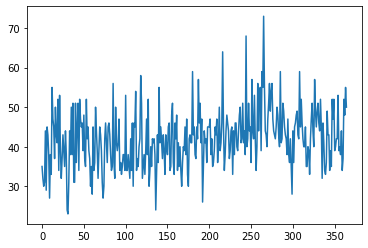

In [21]:
# plot dataset
plt.plot(values)
plt.show()

In [31]:
# transform the time series data into supervised learning
# we only use the previous 6 time steps as input to the model
data = series_to_supervised(values, n_in=6)

# evaluate (making one-step forecasts for the last 12 months fo data)
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

&gt;expected=42.0, predicted=40.9
&gt;expected=53.0, predicted=37.4
&gt;expected=39.0, predicted=36.9
&gt;expected=40.0, predicted=36.2
&gt;expected=38.0, predicted=41.3
&gt;expected=44.0, predicted=50.3
&gt;expected=34.0, predicted=40.6
&gt;expected=37.0, predicted=36.6
&gt;expected=52.0, predicted=40.7
&gt;expected=48.0, predicted=41.3
&gt;expected=55.0, predicted=39.1
&gt;expected=50.0, predicted=40.8
MAE: 6.860


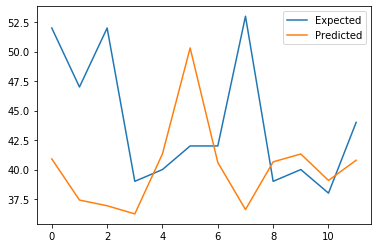

In [32]:
# plot expected vs. preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()